In [7]:
import pandas as pd
import numpy as np

# Загрузка данных из CSV-файла
data = pd.read_csv('./raai_school_2024.csv', delimiter=';')

# Преобразование столбца payment_period в формат даты
data['payment_period'] = pd.to_datetime(data['payment_period'], format='%Y-%m-%d')

# Просмотр первых строк и информации о DataFrame
print(data.head())
print(data.info())

# Вывод основных статистических характеристик
numeric_columns = ['income', 'debt', 'raised', 'volume_cold', 'volume_hot', 'volume_electr']
statistics = data[numeric_columns].describe().T
statistics['missing'] = data[numeric_columns].isnull().sum()
statistics['variance'] = data[numeric_columns].var()

print(statistics)


   house_tkn  flat_tkn payment_period   income     debt   raised  volume_cold  \
0          2     23170     2023-01-01  2073.48  2046.36     0.00         5.33   
1          2     23170     2023-03-01  1525.44  2484.21  2404.08         5.19   
2          2     23170     2023-04-01  1762.49  2337.36  1672.29         5.00   
3          2     23170     2023-05-01  1868.41     0.00  4099.85         5.08   
4          2     23170     2023-07-01  2682.54  1933.29     0.00         8.64   

   volume_hot  volume_electr  
0     6.91416         199.50  
1     4.22532         186.00  
2     4.82284         227.50  
3     5.13227         242.03  
4     6.91416         362.00  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3206079 entries, 0 to 3206078
Data columns (total 9 columns):
 #   Column          Dtype         
---  ------          -----         
 0   house_tkn       int64         
 1   flat_tkn        int64         
 2   payment_period  datetime64[ns]
 3   income          float64       

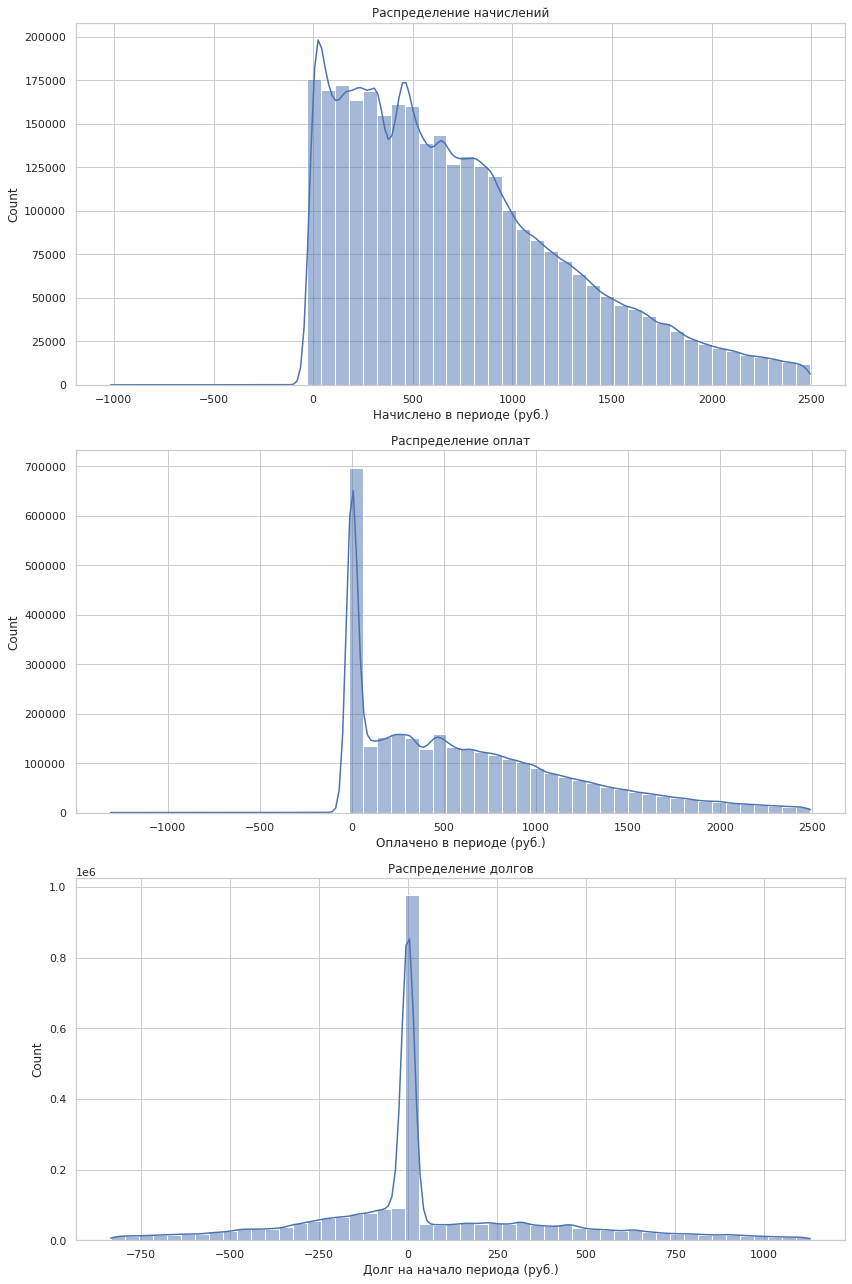

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Установка стиля для графиков
sns.set(style="whitegrid")

# Удаление выбросов
def remove_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return series[(series >= lower_bound) & (series <= upper_bound)]

# Применение функции для удаления выбросов
income_filtered = remove_outliers(data['income'].dropna())
raised_filtered = remove_outliers(data['raised'].dropna())
debt_filtered = remove_outliers(data['debt'].dropna())

# Гистограммы распределения начислений, оплат и долгов
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

sns.histplot(income_filtered, bins=50, kde=True, ax=axes[0])
axes[0].set_title('Распределение начислений')
axes[0].set_xlabel('Начислено в периоде (руб.)')

sns.histplot(raised_filtered, bins=50, kde=True, ax=axes[1])
axes[1].set_title('Распределение оплат')
axes[1].set_xlabel('Оплачено в периоде (руб.)')

sns.histplot(debt_filtered, bins=50, kde=True, ax=axes[2])
axes[2].set_title('Распределение долгов')
axes[2].set_xlabel('Долг на начало периода (руб.)')

plt.tight_layout()
plt.show()


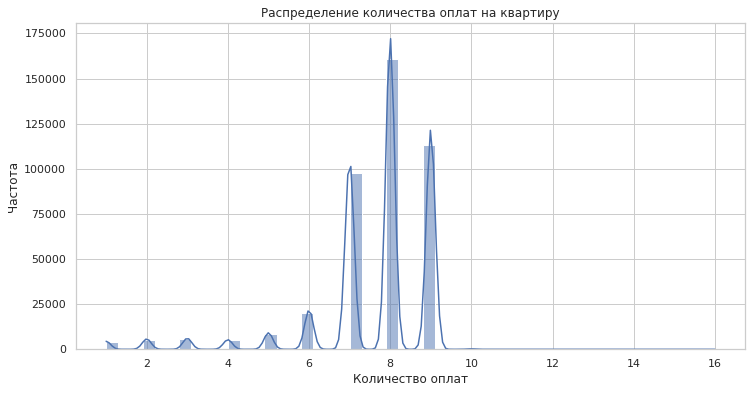

In [4]:
# Подсчет количества оплат для каждой квартиры
payment_counts = data.groupby('flat_tkn')['raised'].count().reset_index()
payment_counts.columns = ['flat_tkn', 'payment_count']

# Гистограмма частоты оплат
plt.figure(figsize=(12, 6))
sns.histplot(payment_counts['payment_count'], bins=50, kde=True)
plt.title('Распределение количества оплат на квартиру')
plt.xlabel('Количество оплат')
plt.ylabel('Частота')
plt.show()


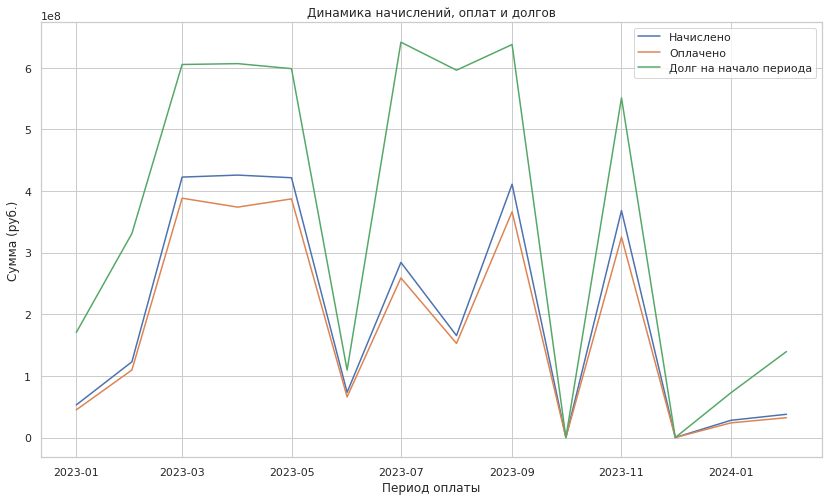

In [5]:
# Группировка данных по периодам оплаты и вычисление суммы начислений, оплат и долгов
monthly_data = data.groupby('payment_period').sum()[['income', 'raised', 'debt']].reset_index()

# Линейные графики динамики начислений, оплат и долгов
plt.figure(figsize=(14, 8))
plt.plot(monthly_data['payment_period'], monthly_data['income'], label='Начислено')
plt.plot(monthly_data['payment_period'], monthly_data['raised'], label='Оплачено')
plt.plot(monthly_data['payment_period'], monthly_data['debt'], label='Долг на начало периода')
plt.title('Динамика начислений, оплат и долгов')
plt.xlabel('Период оплаты')
plt.ylabel('Сумма (руб.)')
plt.legend()
plt.grid(True)
plt.show()


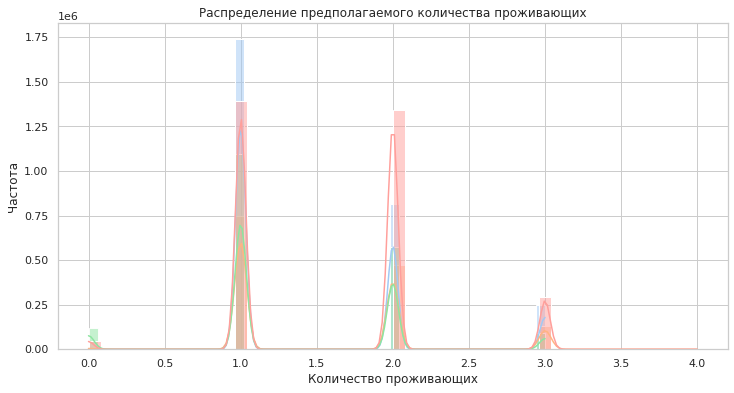

In [13]:
# Нормативы потребления ресурсов на одного человека
norm_cold_water = 6.0  # куб.м. на человека в месяц
norm_hot_water = 3.0  # куб.м. на человека в месяц
norm_electricity = 150.0  # кВт*ч на человека в месяц

# Рассчет предполагаемого количества проживающих на основе потребления ресурсов
data['estimated_people_cold'] = np.ceil(remove_outliers(data['volume_cold']) / norm_cold_water)
data['estimated_people_hot'] = np.ceil(remove_outliers(data['volume_hot']) / norm_hot_water)
data['estimated_people_electr'] = np.ceil(remove_outliers(data['volume_electr']) / norm_electricity)

# Обработка случаев, где нет данных (NaN) по некоторым ресурсам
# Использование np.nanmean для пропуска NaN значений при вычислении среднего
data['estimated_people'] = np.ceil(data[['estimated_people_cold', 'estimated_people_hot', 'estimated_people_electr']].mean(axis=1, skipna=True))

# Гистограмма предполагаемого количества проживающих
plt.figure(figsize=(12, 6))

palette = sns.color_palette("pastel", 4)

sns.histplot(data['estimated_people_cold'].dropna(), bins=50, kde=True, color=palette[0])
sns.histplot(data['estimated_people_hot'].dropna(), bins=50, kde=True, color=palette[1])
sns.histplot(data['estimated_people_electr'].dropna(), bins=50, kde=True, color=palette[2])
sns.histplot(data['estimated_people'].dropna(), bins=50, kde=True, color=palette[3])
plt.title('Распределение предполагаемого количества проживающих')
plt.xlabel('Количество проживающих')
plt.ylabel('Частота')
plt.show()